In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import logging


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
tf.keras.backend.clear_session()
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Layer, Reshape, InputLayer
from tqdm import tqdm

In [3]:
from alibi_detect.models.tensorflow.losses import elbo
from alibi_detect.od import OutlierVAE
from alibi_detect.utils.fetching import fetch_detector
from alibi_detect.utils.perturbation import apply_mask
from alibi_detect.utils.saving import save_detector, load_detector
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image

logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1.0/255)

datagen_generator = datagen.flow_from_directory(
    '../Data/InternalTest/inliers/',
    target_size=(480, 752), batch_size=8,
    shuffle=True, 
)

Found 138398 images belonging to 2 classes.


In [5]:
latent_dim = 1024

encoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=(480, 752, 3)),
      Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(32, 4, strides=2, padding='same', activation=tf.nn.relu)
  ])
encoder_net.summary()
decoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=(latent_dim,)),
      Dense(47*30*32),
      Reshape(target_shape=(30, 47, 32)),
      Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2DTranspose(128, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2DTranspose(32, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')
  ])
decoder_net.summary()
# initialize outlier detector


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 240, 376, 64)      3136      
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 188, 128)     131200    
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 94, 128)       262272    
                                                                 
 conv2d_3 (Conv2D)           (None, 30, 47, 32)        65568     
                                                                 
Total params: 462,176
Trainable params: 462,176
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)              

In [6]:
od = OutlierVAE(threshold=.015,  # threshold for outlier score
                score_type='mse',  # use MSE of reconstruction error for outlier detection
                encoder_net=encoder_net,  # can also pass VAE model instead
                decoder_net=decoder_net,  # of separate encoder and decoder
                latent_dim=latent_dim,
                samples=2)

In [ ]:
import gc
epochs = 10 
ctr = 0
savepath = './saves/outlierdetector_'
for e in range(epochs): 
    for _ in range(len(datagen_generator)): 
        gc.collect()
        ctr += 1 
        imgs = next(datagen_generator)
        img_train = imgs[0]
        od.fit(img_train,
           loss_fn=elbo,
           cov_elbo=dict(sim=.05),
           epochs=1,
           verbose=True)
        
        # save the trained outlier detector
        if ctr % 173*2 == 0: 
            filepath = savepath + str(e) + "_" + str(ctr)
            save_detector(od, filepath)
            


1/1 [=] - 0s 219ms/step - loss_ma: -2100135.5000


1/1 [=] - 0s 222ms/step - loss_ma: -2117220.7500


Directory saves\outlierdetector_0_173 does not exist and is now created.
Directory saves\outlierdetector_0_173\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2171847.5000


1/1 [=] - 0s 220ms/step - loss_ma: -2182146.5000


Directory saves\outlierdetector_0_346 does not exist and is now created.
Directory saves\outlierdetector_0_346\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2177799.0000


1/1 [=] - 0s 220ms/step - loss_ma: -2163187.0000


Directory saves\outlierdetector_0_519 does not exist and is now created.
Directory saves\outlierdetector_0_519\model does not exist and is now created.


1/1 [=] - 0s 218ms/step - loss_ma: -2172822.2500


1/1 [=] - 0s 219ms/step - loss_ma: -2157369.7500


Directory saves\outlierdetector_0_692 does not exist and is now created.
Directory saves\outlierdetector_0_692\model does not exist and is now created.


1/1 [=] - 0s 217ms/step - loss_ma: -2161916.7500


1/1 [=] - 0s 218ms/step - loss_ma: -2179908.5000


Directory saves\outlierdetector_0_865 does not exist and is now created.
Directory saves\outlierdetector_0_865\model does not exist and is now created.


1/1 [=] - 0s 224ms/step - loss_ma: -2203823.7500


1/1 [=] - 0s 219ms/step - loss_ma: -2208427.0000


Directory saves\outlierdetector_0_1038 does not exist and is now created.
Directory saves\outlierdetector_0_1038\model does not exist and is now created.


1/1 [=] - 0s 223ms/step - loss_ma: -2214920.2500


1/1 [=] - 0s 219ms/step - loss_ma: -2213124.0000


Directory saves\outlierdetector_0_1211 does not exist and is now created.
Directory saves\outlierdetector_0_1211\model does not exist and is now created.


1/1 [=] - 0s 223ms/step - loss_ma: -2226657.7500


1/1 [=] - 0s 224ms/step - loss_ma: -2223804.2500


Directory saves\outlierdetector_0_1384 does not exist and is now created.
Directory saves\outlierdetector_0_1384\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -1934283.0000


1/1 [=] - 0s 221ms/step - loss_ma: -2102964.7500


Directory saves\outlierdetector_0_1557 does not exist and is now created.
Directory saves\outlierdetector_0_1557\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2228680.2500


1/1 [=] - 0s 221ms/step - loss_ma: -2223076.7500


Directory saves\outlierdetector_0_1730 does not exist and is now created.
Directory saves\outlierdetector_0_1730\model does not exist and is now created.


1/1 [=] - 0s 223ms/step - loss_ma: -2228832.5000


1/1 [=] - 0s 219ms/step - loss_ma: -2227842.0000


Directory saves\outlierdetector_0_1903 does not exist and is now created.
Directory saves\outlierdetector_0_1903\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2231799.2500


1/1 [=] - 0s 220ms/step - loss_ma: -2232143.0000


Directory saves\outlierdetector_0_2076 does not exist and is now created.
Directory saves\outlierdetector_0_2076\model does not exist and is now created.


1/1 [=] - 0s 222ms/step - loss_ma: -2211885.5000


1/1 [=] - 0s 223ms/step - loss_ma: -2232852.7500


Directory saves\outlierdetector_0_2249 does not exist and is now created.
Directory saves\outlierdetector_0_2249\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2232572.7500


1/1 [=] - 0s 220ms/step - loss_ma: -2229019.2500


Directory saves\outlierdetector_0_2422 does not exist and is now created.
Directory saves\outlierdetector_0_2422\model does not exist and is now created.


1/1 [=] - 0s 224ms/step - loss_ma: -2225500.0000


1/1 [=] - 0s 221ms/step - loss_ma: -2226913.7500


Directory saves\outlierdetector_0_2595 does not exist and is now created.
Directory saves\outlierdetector_0_2595\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2234950.2500


1/1 [=] - 0s 220ms/step - loss_ma: -2197888.2500


Directory saves\outlierdetector_0_2768 does not exist and is now created.
Directory saves\outlierdetector_0_2768\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2232792.0000


1/1 [=] - 0s 219ms/step - loss_ma: -2235474.7500


Directory saves\outlierdetector_0_2941 does not exist and is now created.
Directory saves\outlierdetector_0_2941\model does not exist and is now created.


1/1 [=] - 0s 219ms/step - loss_ma: -2231362.0000


1/1 [=] - 0s 223ms/step - loss_ma: -2234629.0000


Directory saves\outlierdetector_0_3114 does not exist and is now created.
Directory saves\outlierdetector_0_3114\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2212682.0000


1/1 [=] - 0s 218ms/step - loss_ma: -2236484.2500


Directory saves\outlierdetector_0_3287 does not exist and is now created.
Directory saves\outlierdetector_0_3287\model does not exist and is now created.


1/1 [=] - 0s 218ms/step - loss_ma: -2113946.7500


1/1 [=] - 0s 223ms/step - loss_ma: -2115548.5000


Directory saves\outlierdetector_0_3460 does not exist and is now created.
Directory saves\outlierdetector_0_3460\model does not exist and is now created.


1/1 [=] - 0s 229ms/step - loss_ma: -2156613.0000


1/1 [=] - 0s 220ms/step - loss_ma: -2159763.0000


Directory saves\outlierdetector_0_3633 does not exist and is now created.
Directory saves\outlierdetector_0_3633\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2185467.0000


1/1 [=] - 0s 222ms/step - loss_ma: -2180007.2500


Directory saves\outlierdetector_0_3806 does not exist and is now created.
Directory saves\outlierdetector_0_3806\model does not exist and is now created.


1/1 [=] - 0s 219ms/step - loss_ma: -2163682.0000


1/1 [=] - 0s 221ms/step - loss_ma: -2190490.7500


Directory saves\outlierdetector_0_3979 does not exist and is now created.
Directory saves\outlierdetector_0_3979\model does not exist and is now created.


1/1 [=] - 0s 222ms/step - loss_ma: -2187207.2500


1/1 [=] - 0s 219ms/step - loss_ma: -2185817.0000


Directory saves\outlierdetector_0_4152 does not exist and is now created.
Directory saves\outlierdetector_0_4152\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2177147.7500


1/1 [=] - 0s 221ms/step - loss_ma: -2195399.5000


Directory saves\outlierdetector_0_4325 does not exist and is now created.
Directory saves\outlierdetector_0_4325\model does not exist and is now created.


1/1 [=] - 0s 223ms/step - loss_ma: -2187019.0000


1/1 [=] - 0s 222ms/step - loss_ma: -2185194.5000


Directory saves\outlierdetector_0_4498 does not exist and is now created.
Directory saves\outlierdetector_0_4498\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2184501.5000


1/1 [=] - 0s 220ms/step - loss_ma: -2165353.0000


Directory saves\outlierdetector_0_4671 does not exist and is now created.
Directory saves\outlierdetector_0_4671\model does not exist and is now created.


1/1 [=] - 0s 218ms/step - loss_ma: -2191740.2500


1/1 [=] - 0s 221ms/step - loss_ma: -2190657.0000


Directory saves\outlierdetector_0_4844 does not exist and is now created.
Directory saves\outlierdetector_0_4844\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2178535.2500


1/1 [=] - 0s 220ms/step - loss_ma: -2190560.2500


Directory saves\outlierdetector_0_5017 does not exist and is now created.
Directory saves\outlierdetector_0_5017\model does not exist and is now created.


1/1 [=] - 0s 222ms/step - loss_ma: -2185215.2500


1/1 [=] - 0s 221ms/step - loss_ma: -2192177.7500


Directory saves\outlierdetector_0_5190 does not exist and is now created.
Directory saves\outlierdetector_0_5190\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2178744.5000


1/1 [=] - 0s 220ms/step - loss_ma: -2191604.0000


Directory saves\outlierdetector_0_5363 does not exist and is now created.
Directory saves\outlierdetector_0_5363\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2208008.2500


1/1 [=] - 0s 223ms/step - loss_ma: -2197350.7500


Directory saves\outlierdetector_0_5536 does not exist and is now created.
Directory saves\outlierdetector_0_5536\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2135549.7500


1/1 [=] - 0s 222ms/step - loss_ma: -2166271.7500


Directory saves\outlierdetector_0_5709 does not exist and is now created.
Directory saves\outlierdetector_0_5709\model does not exist and is now created.


1/1 [=] - 0s 222ms/step - loss_ma: -2188845.2500


1/1 [=] - 0s 219ms/step - loss_ma: -2153760.7500


Directory saves\outlierdetector_0_5882 does not exist and is now created.
Directory saves\outlierdetector_0_5882\model does not exist and is now created.


1/1 [=] - 0s 222ms/step - loss_ma: -2200421.0000


1/1 [=] - 0s 220ms/step - loss_ma: -2169298.2500


Directory saves\outlierdetector_0_6055 does not exist and is now created.
Directory saves\outlierdetector_0_6055\model does not exist and is now created.


1/1 [=] - 0s 222ms/step - loss_ma: -2181280.0000


1/1 [=] - 0s 220ms/step - loss_ma: -2197219.7500


Directory saves\outlierdetector_0_6228 does not exist and is now created.
Directory saves\outlierdetector_0_6228\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2197226.5000


1/1 [=] - 0s 222ms/step - loss_ma: -2152064.5000


Directory saves\outlierdetector_0_6401 does not exist and is now created.
Directory saves\outlierdetector_0_6401\model does not exist and is now created.


1/1 [=] - 0s 227ms/step - loss_ma: -2194948.7500


1/1 [=] - 0s 222ms/step - loss_ma: -2165889.5000


Directory saves\outlierdetector_0_6574 does not exist and is now created.
Directory saves\outlierdetector_0_6574\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2188042.7500


1/1 [=] - 0s 220ms/step - loss_ma: -2187374.2500


Directory saves\outlierdetector_0_6747 does not exist and is now created.
Directory saves\outlierdetector_0_6747\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2181202.0000


1/1 [=] - 0s 222ms/step - loss_ma: -2209434.2500


Directory saves\outlierdetector_0_6920 does not exist and is now created.
Directory saves\outlierdetector_0_6920\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2188980.5000


1/1 [=] - 0s 220ms/step - loss_ma: -2172106.0000


Directory saves\outlierdetector_0_7093 does not exist and is now created.
Directory saves\outlierdetector_0_7093\model does not exist and is now created.


1/1 [=] - 0s 217ms/step - loss_ma: -2181263.2500


1/1 [=] - 0s 223ms/step - loss_ma: -2192101.0000


Directory saves\outlierdetector_0_7266 does not exist and is now created.
Directory saves\outlierdetector_0_7266\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2181409.2500


1/1 [=] - 0s 220ms/step - loss_ma: -2181471.0000


Directory saves\outlierdetector_0_7439 does not exist and is now created.
Directory saves\outlierdetector_0_7439\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2187385.5000


1/1 [=] - 0s 220ms/step - loss_ma: -2194461.0000


Directory saves\outlierdetector_0_7612 does not exist and is now created.
Directory saves\outlierdetector_0_7612\model does not exist and is now created.


1/1 [=] - 0s 223ms/step - loss_ma: -2177826.2500


1/1 [=] - 0s 220ms/step - loss_ma: -2176077.0000


Directory saves\outlierdetector_0_7785 does not exist and is now created.
Directory saves\outlierdetector_0_7785\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2177803.5000


1/1 [=] - 0s 220ms/step - loss_ma: -2176656.5000


Directory saves\outlierdetector_0_7958 does not exist and is now created.
Directory saves\outlierdetector_0_7958\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2177281.0000


1/1 [=] - 0s 224ms/step - loss_ma: -2183725.7500


Directory saves\outlierdetector_0_8131 does not exist and is now created.
Directory saves\outlierdetector_0_8131\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2179382.5000


1/1 [=] - 0s 222ms/step - loss_ma: -2172492.5000


Directory saves\outlierdetector_0_8304 does not exist and is now created.
Directory saves\outlierdetector_0_8304\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2171174.5000


1/1 [=] - 0s 220ms/step - loss_ma: -2206507.5000


Directory saves\outlierdetector_0_8477 does not exist and is now created.
Directory saves\outlierdetector_0_8477\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2182787.5000


1/1 [=] - 0s 223ms/step - loss_ma: -2182025.0000


Directory saves\outlierdetector_0_8650 does not exist and is now created.
Directory saves\outlierdetector_0_8650\model does not exist and is now created.


1/1 [=] - 0s 219ms/step - loss_ma: -2218329.5000


1/1 [=] - 0s 223ms/step - loss_ma: -2183764.7500


Directory saves\outlierdetector_0_8823 does not exist and is now created.
Directory saves\outlierdetector_0_8823\model does not exist and is now created.


1/1 [=] - 0s 222ms/step - loss_ma: -2231214.0000


1/1 [=] - 0s 221ms/step - loss_ma: -2221051.7500


Directory saves\outlierdetector_0_8996 does not exist and is now created.
Directory saves\outlierdetector_0_8996\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2229339.5000


1/1 [=] - 0s 225ms/step - loss_ma: -2219813.5000


Directory saves\outlierdetector_0_9169 does not exist and is now created.
Directory saves\outlierdetector_0_9169\model does not exist and is now created.


1/1 [=] - 0s 224ms/step - loss_ma: -2219151.0000


1/1 [=] - 0s 217ms/step - loss_ma: -2237576.7500


Directory saves\outlierdetector_0_9342 does not exist and is now created.
Directory saves\outlierdetector_0_9342\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2236984.5000


1/1 [=] - 0s 224ms/step - loss_ma: -2219049.0000


Directory saves\outlierdetector_0_9515 does not exist and is now created.
Directory saves\outlierdetector_0_9515\model does not exist and is now created.


1/1 [=] - 0s 222ms/step - loss_ma: -2238080.2500


1/1 [=] - 0s 221ms/step - loss_ma: -2234981.2500


Directory saves\outlierdetector_0_9688 does not exist and is now created.
Directory saves\outlierdetector_0_9688\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2224271.5000


1/1 [=] - 0s 228ms/step - loss_ma: -2233446.0000


Directory saves\outlierdetector_0_9861 does not exist and is now created.
Directory saves\outlierdetector_0_9861\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2233780.7500


1/1 [=] - 0s 224ms/step - loss_ma: -2212090.5000


Directory saves\outlierdetector_0_10034 does not exist and is now created.
Directory saves\outlierdetector_0_10034\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2238041.0000


1/1 [=] - 0s 219ms/step - loss_ma: -2234162.7500


Directory saves\outlierdetector_0_10207 does not exist and is now created.
Directory saves\outlierdetector_0_10207\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2226441.0000


1/1 [=] - 0s 224ms/step - loss_ma: -2227330.7500


Directory saves\outlierdetector_0_10380 does not exist and is now created.
Directory saves\outlierdetector_0_10380\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2224365.2500


1/1 [=] - 0s 221ms/step - loss_ma: -2234713.0000


Directory saves\outlierdetector_0_10553 does not exist and is now created.
Directory saves\outlierdetector_0_10553\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2238187.5000


1/1 [=] - 0s 222ms/step - loss_ma: -2237674.5000


Directory saves\outlierdetector_0_10726 does not exist and is now created.
Directory saves\outlierdetector_0_10726\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2232882.5000


1/1 [=] - 0s 221ms/step - loss_ma: -2221636.5000


Directory saves\outlierdetector_0_10899 does not exist and is now created.
Directory saves\outlierdetector_0_10899\model does not exist and is now created.


1/1 [=] - 0s 222ms/step - loss_ma: -2219418.5000


1/1 [=] - 0s 221ms/step - loss_ma: -2234664.0000


Directory saves\outlierdetector_0_11072 does not exist and is now created.
Directory saves\outlierdetector_0_11072\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2233115.0000


1/1 [=] - 0s 222ms/step - loss_ma: -2231835.5000


Directory saves\outlierdetector_0_11245 does not exist and is now created.
Directory saves\outlierdetector_0_11245\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2239657.0000


1/1 [=] - 0s 222ms/step - loss_ma: -2234874.2500


Directory saves\outlierdetector_0_11418 does not exist and is now created.
Directory saves\outlierdetector_0_11418\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2238552.7500


1/1 [=] - 0s 217ms/step - loss_ma: -2232097.0000


Directory saves\outlierdetector_0_11591 does not exist and is now created.
Directory saves\outlierdetector_0_11591\model does not exist and is now created.


1/1 [=] - 0s 223ms/step - loss_ma: -2237079.0000


1/1 [=] - 0s 221ms/step - loss_ma: -2234820.0000


Directory saves\outlierdetector_0_11764 does not exist and is now created.
Directory saves\outlierdetector_0_11764\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2238088.0000


1/1 [=] - 0s 222ms/step - loss_ma: -2240524.2500


Directory saves\outlierdetector_0_11937 does not exist and is now created.
Directory saves\outlierdetector_0_11937\model does not exist and is now created.


1/1 [=] - 0s 223ms/step - loss_ma: -2234178.0000


1/1 [=] - 0s 223ms/step - loss_ma: -2228662.5000


Directory saves\outlierdetector_0_12110 does not exist and is now created.
Directory saves\outlierdetector_0_12110\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2237159.5000


1/1 [=] - 0s 221ms/step - loss_ma: -2239039.5000


Directory saves\outlierdetector_0_12283 does not exist and is now created.
Directory saves\outlierdetector_0_12283\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2239326.0000


1/1 [=] - 0s 222ms/step - loss_ma: -2236765.2500


Directory saves\outlierdetector_0_12456 does not exist and is now created.
Directory saves\outlierdetector_0_12456\model does not exist and is now created.


1/1 [=] - 0s 227ms/step - loss_ma: -2240001.2500


1/1 [=] - 0s 220ms/step - loss_ma: -2239606.2500


Directory saves\outlierdetector_0_12629 does not exist and is now created.
Directory saves\outlierdetector_0_12629\model does not exist and is now created.


1/1 [=] - 0s 223ms/step - loss_ma: -2239316.7500


1/1 [=] - 0s 217ms/step - loss_ma: -2238122.2500


Directory saves\outlierdetector_0_12802 does not exist and is now created.
Directory saves\outlierdetector_0_12802\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2221277.2500


1/1 [=] - 0s 225ms/step - loss_ma: -2240597.2500


Directory saves\outlierdetector_0_12975 does not exist and is now created.
Directory saves\outlierdetector_0_12975\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2236665.0000


1/1 [=] - 0s 218ms/step - loss_ma: -2239302.0000


Directory saves\outlierdetector_0_13148 does not exist and is now created.
Directory saves\outlierdetector_0_13148\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2240618.0000


1/1 [=] - 0s 222ms/step - loss_ma: -2233511.5000


Directory saves\outlierdetector_0_13321 does not exist and is now created.
Directory saves\outlierdetector_0_13321\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2233297.7500


1/1 [=] - 0s 222ms/step - loss_ma: -2241320.0000


Directory saves\outlierdetector_0_13494 does not exist and is now created.
Directory saves\outlierdetector_0_13494\model does not exist and is now created.


1/1 [=] - 0s 222ms/step - loss_ma: -2239599.2500


1/1 [=] - 0s 222ms/step - loss_ma: -2231679.2500


Directory saves\outlierdetector_0_13667 does not exist and is now created.
Directory saves\outlierdetector_0_13667\model does not exist and is now created.


1/1 [=] - 0s 219ms/step - loss_ma: -2239572.7500


1/1 [=] - 0s 221ms/step - loss_ma: -2237540.0000


Directory saves\outlierdetector_0_13840 does not exist and is now created.
Directory saves\outlierdetector_0_13840\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2236958.2500


1/1 [=] - 0s 224ms/step - loss_ma: -2237934.2500


Directory saves\outlierdetector_0_14013 does not exist and is now created.
Directory saves\outlierdetector_0_14013\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2230387.5000


1/1 [=] - 0s 221ms/step - loss_ma: -2237606.7500


Directory saves\outlierdetector_0_14186 does not exist and is now created.
Directory saves\outlierdetector_0_14186\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2235161.5000


1/1 [=] - 0s 220ms/step - loss_ma: -2236936.5000


Directory saves\outlierdetector_0_14359 does not exist and is now created.
Directory saves\outlierdetector_0_14359\model does not exist and is now created.


1/1 [=] - 0s 223ms/step - loss_ma: -2238615.2500


1/1 [=] - 0s 222ms/step - loss_ma: -2217106.7500


Directory saves\outlierdetector_0_14532 does not exist and is now created.
Directory saves\outlierdetector_0_14532\model does not exist and is now created.


1/1 [=] - 0s 219ms/step - loss_ma: -2241251.7500


1/1 [=] - 0s 220ms/step - loss_ma: -2239741.5000


Directory saves\outlierdetector_0_14705 does not exist and is now created.
Directory saves\outlierdetector_0_14705\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2238524.2500


1/1 [=] - 0s 220ms/step - loss_ma: -2233109.5000


Directory saves\outlierdetector_0_14878 does not exist and is now created.
Directory saves\outlierdetector_0_14878\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2239769.0000


1/1 [=] - 0s 223ms/step - loss_ma: -2241147.7500


Directory saves\outlierdetector_0_15051 does not exist and is now created.
Directory saves\outlierdetector_0_15051\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2238959.2500


1/1 [=] - 0s 218ms/step - loss_ma: -2234934.2500


Directory saves\outlierdetector_0_15224 does not exist and is now created.
Directory saves\outlierdetector_0_15224\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2239851.7500


1/1 [=] - 0s 221ms/step - loss_ma: -2240252.7500


Directory saves\outlierdetector_0_15397 does not exist and is now created.
Directory saves\outlierdetector_0_15397\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2240774.0000


1/1 [=] - 0s 220ms/step - loss_ma: -2226808.5000


Directory saves\outlierdetector_0_15570 does not exist and is now created.
Directory saves\outlierdetector_0_15570\model does not exist and is now created.


1/1 [=] - 0s 219ms/step - loss_ma: -2241880.0000


1/1 [=] - 0s 234ms/step - loss_ma: -2242341.2500


Directory saves\outlierdetector_0_15743 does not exist and is now created.
Directory saves\outlierdetector_0_15743\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2239244.5000


1/1 [=] - 0s 220ms/step - loss_ma: -2240975.5000


Directory saves\outlierdetector_0_15916 does not exist and is now created.
Directory saves\outlierdetector_0_15916\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2240412.2500


1/1 [=] - 0s 221ms/step - loss_ma: -2237749.2500


Directory saves\outlierdetector_0_16089 does not exist and is now created.
Directory saves\outlierdetector_0_16089\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2242112.0000


1/1 [=] - 0s 221ms/step - loss_ma: -2242311.7500


Directory saves\outlierdetector_0_16262 does not exist and is now created.
Directory saves\outlierdetector_0_16262\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2241449.7500


1/1 [=] - 0s 221ms/step - loss_ma: -2240441.5000


Directory saves\outlierdetector_0_16435 does not exist and is now created.
Directory saves\outlierdetector_0_16435\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2242473.2500


1/1 [=] - 0s 222ms/step - loss_ma: -2241801.0000


Directory saves\outlierdetector_0_16608 does not exist and is now created.
Directory saves\outlierdetector_0_16608\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2235108.2500


1/1 [=] - 0s 220ms/step - loss_ma: -2239950.7500


Directory saves\outlierdetector_0_16781 does not exist and is now created.
Directory saves\outlierdetector_0_16781\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2237816.2500


1/1 [=] - 0s 221ms/step - loss_ma: -2240076.0000


Directory saves\outlierdetector_0_16954 does not exist and is now created.
Directory saves\outlierdetector_0_16954\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2241467.5000


1/1 [=] - 0s 221ms/step - loss_ma: -2240927.2500


Directory saves\outlierdetector_0_17127 does not exist and is now created.
Directory saves\outlierdetector_0_17127\model does not exist and is now created.


1/1 [=] - 0s 229ms/step - loss_ma: -2242207.0000


1/1 [=] - 1s 844ms/step - loss_ma: -2240017.0000


Directory saves\outlierdetector_0_17300 does not exist and is now created.
Directory saves\outlierdetector_0_17300\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2242471.0000


1/1 [=] - 0s 218ms/step - loss_ma: -2241823.7500


Directory saves\outlierdetector_1_17473 does not exist and is now created.
Directory saves\outlierdetector_1_17473\model does not exist and is now created.


1/1 [=] - 0s 219ms/step - loss_ma: -2236001.2500


1/1 [=] - 0s 220ms/step - loss_ma: -2242428.0000


Directory saves\outlierdetector_1_17646 does not exist and is now created.
Directory saves\outlierdetector_1_17646\model does not exist and is now created.


1/1 [=] - 0s 219ms/step - loss_ma: -2236897.7500


1/1 [=] - 0s 218ms/step - loss_ma: -2235370.5000


Directory saves\outlierdetector_1_17819 does not exist and is now created.
Directory saves\outlierdetector_1_17819\model does not exist and is now created.


1/1 [=] - 0s 224ms/step - loss_ma: -2241481.7500


1/1 [=] - 0s 221ms/step - loss_ma: -2237666.0000


Directory saves\outlierdetector_1_17992 does not exist and is now created.
Directory saves\outlierdetector_1_17992\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2241231.0000


1/1 [=] - 0s 220ms/step - loss_ma: -2242110.5000


Directory saves\outlierdetector_1_18165 does not exist and is now created.
Directory saves\outlierdetector_1_18165\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2240413.5000


1/1 [=] - 0s 221ms/step - loss_ma: -2235292.0000


Directory saves\outlierdetector_1_18338 does not exist and is now created.
Directory saves\outlierdetector_1_18338\model does not exist and is now created.


1/1 [=] - 0s 219ms/step - loss_ma: -2241989.0000


1/1 [=] - 0s 220ms/step - loss_ma: -2242002.5000


Directory saves\outlierdetector_1_18511 does not exist and is now created.
Directory saves\outlierdetector_1_18511\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2222338.2500


1/1 [=] - 0s 220ms/step - loss_ma: -2238259.0000


Directory saves\outlierdetector_1_18684 does not exist and is now created.
Directory saves\outlierdetector_1_18684\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2242297.0000


1/1 [=] - 0s 219ms/step - loss_ma: -2242894.7500


Directory saves\outlierdetector_1_18857 does not exist and is now created.
Directory saves\outlierdetector_1_18857\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2242329.5000


1/1 [=] - 0s 218ms/step - loss_ma: -2240437.7500


Directory saves\outlierdetector_1_19030 does not exist and is now created.
Directory saves\outlierdetector_1_19030\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2241749.5000


1/1 [=] - 0s 217ms/step - loss_ma: -2228092.2500


Directory saves\outlierdetector_1_19203 does not exist and is now created.
Directory saves\outlierdetector_1_19203\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2242417.7500


1/1 [=] - 0s 222ms/step - loss_ma: -2239722.0000


Directory saves\outlierdetector_1_19376 does not exist and is now created.
Directory saves\outlierdetector_1_19376\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2241003.7500


1/1 [=] - 0s 220ms/step - loss_ma: -2237157.2500


Directory saves\outlierdetector_1_19549 does not exist and is now created.
Directory saves\outlierdetector_1_19549\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2241952.0000


1/1 [=] - 0s 220ms/step - loss_ma: -2241888.5000


Directory saves\outlierdetector_1_19722 does not exist and is now created.
Directory saves\outlierdetector_1_19722\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2233291.7500


1/1 [=] - 0s 222ms/step - loss_ma: -2239689.7500


Directory saves\outlierdetector_1_19895 does not exist and is now created.
Directory saves\outlierdetector_1_19895\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2243076.5000


1/1 [=] - 0s 217ms/step - loss_ma: -2241409.7500


Directory saves\outlierdetector_1_20068 does not exist and is now created.
Directory saves\outlierdetector_1_20068\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2243031.0000


1/1 [=] - 0s 219ms/step - loss_ma: -2242629.5000


Directory saves\outlierdetector_1_20241 does not exist and is now created.
Directory saves\outlierdetector_1_20241\model does not exist and is now created.


1/1 [=] - 0s 219ms/step - loss_ma: -2241474.5000


1/1 [=] - 0s 221ms/step - loss_ma: -2242211.0000


Directory saves\outlierdetector_1_20414 does not exist and is now created.
Directory saves\outlierdetector_1_20414\model does not exist and is now created.


1/1 [=] - 0s 223ms/step - loss_ma: -2240477.5000


1/1 [=] - 0s 220ms/step - loss_ma: -2240085.0000


Directory saves\outlierdetector_1_20587 does not exist and is now created.
Directory saves\outlierdetector_1_20587\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2241252.5000


1/1 [=] - 0s 222ms/step - loss_ma: -2237697.5000


Directory saves\outlierdetector_1_20760 does not exist and is now created.
Directory saves\outlierdetector_1_20760\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2240150.5000


1/1 [=] - 0s 217ms/step - loss_ma: -2240674.5000


Directory saves\outlierdetector_1_20933 does not exist and is now created.
Directory saves\outlierdetector_1_20933\model does not exist and is now created.


1/1 [=] - 0s 223ms/step - loss_ma: -2240629.2500


1/1 [=] - 0s 220ms/step - loss_ma: -2239625.5000


Directory saves\outlierdetector_1_21106 does not exist and is now created.
Directory saves\outlierdetector_1_21106\model does not exist and is now created.


1/1 [=] - 0s 223ms/step - loss_ma: -2241012.0000


1/1 [=] - 0s 220ms/step - loss_ma: -2240722.5000


Directory saves\outlierdetector_1_21279 does not exist and is now created.
Directory saves\outlierdetector_1_21279\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2242393.7500


1/1 [=] - 0s 222ms/step - loss_ma: -2241304.0000


Directory saves\outlierdetector_1_21452 does not exist and is now created.
Directory saves\outlierdetector_1_21452\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2238201.5000


1/1 [=] - 0s 221ms/step - loss_ma: -2242927.7500


Directory saves\outlierdetector_1_21625 does not exist and is now created.
Directory saves\outlierdetector_1_21625\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2238582.0000


1/1 [=] - 0s 220ms/step - loss_ma: -2235928.0000


Directory saves\outlierdetector_1_21798 does not exist and is now created.
Directory saves\outlierdetector_1_21798\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2242125.5000


1/1 [=] - 0s 221ms/step - loss_ma: -2236840.0000


Directory saves\outlierdetector_1_21971 does not exist and is now created.
Directory saves\outlierdetector_1_21971\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2239443.5000


1/1 [=] - 0s 220ms/step - loss_ma: -2234914.7500


Directory saves\outlierdetector_1_22144 does not exist and is now created.
Directory saves\outlierdetector_1_22144\model does not exist and is now created.


1/1 [=] - 0s 218ms/step - loss_ma: -2220686.7500


1/1 [=] - 0s 222ms/step - loss_ma: -2241942.0000


Directory saves\outlierdetector_1_22317 does not exist and is now created.
Directory saves\outlierdetector_1_22317\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2238009.5000


1/1 [=] - 0s 223ms/step - loss_ma: -2211842.5000


Directory saves\outlierdetector_1_22490 does not exist and is now created.
Directory saves\outlierdetector_1_22490\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2240701.7500


1/1 [=] - 0s 220ms/step - loss_ma: -2242283.0000


Directory saves\outlierdetector_1_22663 does not exist and is now created.
Directory saves\outlierdetector_1_22663\model does not exist and is now created.


1/1 [=] - 0s 219ms/step - loss_ma: -2241291.5000


1/1 [=] - 0s 221ms/step - loss_ma: -2243087.7500


Directory saves\outlierdetector_1_22836 does not exist and is now created.
Directory saves\outlierdetector_1_22836\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2237099.0000


1/1 [=] - 0s 221ms/step - loss_ma: -2241266.7500


Directory saves\outlierdetector_1_23009 does not exist and is now created.
Directory saves\outlierdetector_1_23009\model does not exist and is now created.


1/1 [=] - 0s 218ms/step - loss_ma: -2239617.5000


1/1 [=] - 0s 217ms/step - loss_ma: -2241953.5000


Directory saves\outlierdetector_1_23182 does not exist and is now created.
Directory saves\outlierdetector_1_23182\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2243093.0000


1/1 [=] - 0s 218ms/step - loss_ma: -2235804.0000


Directory saves\outlierdetector_1_23355 does not exist and is now created.
Directory saves\outlierdetector_1_23355\model does not exist and is now created.


1/1 [=] - 0s 222ms/step - loss_ma: -2242464.5000


1/1 [=] - 0s 218ms/step - loss_ma: -2235035.7500


Directory saves\outlierdetector_1_23528 does not exist and is now created.
Directory saves\outlierdetector_1_23528\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2243367.7500


1/1 [=] - 0s 218ms/step - loss_ma: -2242321.2500


Directory saves\outlierdetector_1_23701 does not exist and is now created.
Directory saves\outlierdetector_1_23701\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2241679.5000


1/1 [=] - 0s 217ms/step - loss_ma: -2243207.5000


Directory saves\outlierdetector_1_23874 does not exist and is now created.
Directory saves\outlierdetector_1_23874\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2233471.2500


1/1 [=] - 0s 223ms/step - loss_ma: -2241352.5000


Directory saves\outlierdetector_1_24047 does not exist and is now created.
Directory saves\outlierdetector_1_24047\model does not exist and is now created.


1/1 [=] - 0s 223ms/step - loss_ma: -2225913.0000


1/1 [=] - 0s 222ms/step - loss_ma: -2233767.7500


Directory saves\outlierdetector_1_24220 does not exist and is now created.
Directory saves\outlierdetector_1_24220\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2241566.7500


1/1 [=] - 0s 221ms/step - loss_ma: -2242964.0000


Directory saves\outlierdetector_1_24393 does not exist and is now created.
Directory saves\outlierdetector_1_24393\model does not exist and is now created.


1/1 [=] - 0s 222ms/step - loss_ma: -2239662.5000


1/1 [=] - 0s 219ms/step - loss_ma: -2242293.5000


Directory saves\outlierdetector_1_24566 does not exist and is now created.
Directory saves\outlierdetector_1_24566\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2242919.5000


1/1 [=] - 0s 221ms/step - loss_ma: -2238479.5000


Directory saves\outlierdetector_1_24739 does not exist and is now created.
Directory saves\outlierdetector_1_24739\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2243310.5000


1/1 [=] - 0s 222ms/step - loss_ma: -2238486.0000


Directory saves\outlierdetector_1_24912 does not exist and is now created.
Directory saves\outlierdetector_1_24912\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2242718.7500


1/1 [=] - 0s 222ms/step - loss_ma: -2236964.2500


Directory saves\outlierdetector_1_25085 does not exist and is now created.
Directory saves\outlierdetector_1_25085\model does not exist and is now created.


1/1 [=] - 0s 222ms/step - loss_ma: -2242697.0000


1/1 [=] - 0s 221ms/step - loss_ma: -2240687.7500


Directory saves\outlierdetector_1_25258 does not exist and is now created.
Directory saves\outlierdetector_1_25258\model does not exist and is now created.


1/1 [=] - 0s 224ms/step - loss_ma: -2238536.2500


1/1 [=] - 0s 220ms/step - loss_ma: -2242860.7500


Directory saves\outlierdetector_1_25431 does not exist and is now created.
Directory saves\outlierdetector_1_25431\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2233366.2500


1/1 [=] - 0s 223ms/step - loss_ma: -2242902.0000


Directory saves\outlierdetector_1_25604 does not exist and is now created.
Directory saves\outlierdetector_1_25604\model does not exist and is now created.


1/1 [=] - 0s 223ms/step - loss_ma: -2243149.2500


1/1 [=] - 0s 223ms/step - loss_ma: -2242278.0000


Directory saves\outlierdetector_1_25777 does not exist and is now created.
Directory saves\outlierdetector_1_25777\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2226131.0000


1/1 [=] - 0s 221ms/step - loss_ma: -2239266.7500


Directory saves\outlierdetector_1_25950 does not exist and is now created.
Directory saves\outlierdetector_1_25950\model does not exist and is now created.


1/1 [=] - 0s 222ms/step - loss_ma: -2242949.7500


1/1 [=] - 0s 219ms/step - loss_ma: -2241363.7500


Directory saves\outlierdetector_1_26123 does not exist and is now created.
Directory saves\outlierdetector_1_26123\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2243622.7500


1/1 [=] - 0s 228ms/step - loss_ma: -2241121.7500


Directory saves\outlierdetector_1_26296 does not exist and is now created.
Directory saves\outlierdetector_1_26296\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2242627.5000


1/1 [=] - 0s 220ms/step - loss_ma: -2243438.2500


Directory saves\outlierdetector_1_26469 does not exist and is now created.
Directory saves\outlierdetector_1_26469\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2240364.5000


1/1 [=] - 0s 223ms/step - loss_ma: -2241214.7500


Directory saves\outlierdetector_1_26642 does not exist and is now created.
Directory saves\outlierdetector_1_26642\model does not exist and is now created.


1/1 [=] - 0s 223ms/step - loss_ma: -2241357.0000


1/1 [=] - 0s 221ms/step - loss_ma: -2237962.0000


Directory saves\outlierdetector_1_26815 does not exist and is now created.
Directory saves\outlierdetector_1_26815\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2240787.0000


1/1 [=] - 0s 222ms/step - loss_ma: -2243114.5000


Directory saves\outlierdetector_1_26988 does not exist and is now created.
Directory saves\outlierdetector_1_26988\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2241260.0000


1/1 [=] - 0s 223ms/step - loss_ma: -2241802.0000


Directory saves\outlierdetector_1_27161 does not exist and is now created.
Directory saves\outlierdetector_1_27161\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2241925.5000


1/1 [=] - 0s 221ms/step - loss_ma: -2242761.2500


Directory saves\outlierdetector_1_27334 does not exist and is now created.
Directory saves\outlierdetector_1_27334\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2240457.7500


1/1 [=] - 0s 221ms/step - loss_ma: -2240682.5000


Directory saves\outlierdetector_1_27507 does not exist and is now created.
Directory saves\outlierdetector_1_27507\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2235741.7500


1/1 [=] - 0s 221ms/step - loss_ma: -2241712.7500


Directory saves\outlierdetector_1_27680 does not exist and is now created.
Directory saves\outlierdetector_1_27680\model does not exist and is now created.


1/1 [=] - 0s 222ms/step - loss_ma: -2241701.5000


1/1 [=] - 0s 221ms/step - loss_ma: -2241865.5000


Directory saves\outlierdetector_1_27853 does not exist and is now created.
Directory saves\outlierdetector_1_27853\model does not exist and is now created.


1/1 [=] - 0s 224ms/step - loss_ma: -2242119.5000


1/1 [=] - 0s 223ms/step - loss_ma: -2242436.0000


Directory saves\outlierdetector_1_28026 does not exist and is now created.
Directory saves\outlierdetector_1_28026\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2242338.0000


1/1 [=] - 0s 220ms/step - loss_ma: -2238701.7500


Directory saves\outlierdetector_1_28199 does not exist and is now created.
Directory saves\outlierdetector_1_28199\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2243266.0000


1/1 [=] - 0s 220ms/step - loss_ma: -2243117.0000


Directory saves\outlierdetector_1_28372 does not exist and is now created.
Directory saves\outlierdetector_1_28372\model does not exist and is now created.


1/1 [=] - 0s 222ms/step - loss_ma: -2239443.2500


1/1 [=] - 0s 220ms/step - loss_ma: -2243260.0000


Directory saves\outlierdetector_1_28545 does not exist and is now created.
Directory saves\outlierdetector_1_28545\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2243406.0000


1/1 [=] - 0s 218ms/step - loss_ma: -2240813.5000


Directory saves\outlierdetector_1_28718 does not exist and is now created.
Directory saves\outlierdetector_1_28718\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2243164.0000


1/1 [=] - 0s 223ms/step - loss_ma: -2242341.5000


Directory saves\outlierdetector_1_28891 does not exist and is now created.
Directory saves\outlierdetector_1_28891\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2229941.2500


1/1 [=] - 0s 222ms/step - loss_ma: -2241188.7500


Directory saves\outlierdetector_1_29064 does not exist and is now created.
Directory saves\outlierdetector_1_29064\model does not exist and is now created.


1/1 [=] - 0s 225ms/step - loss_ma: -2241248.5000


1/1 [=] - 0s 221ms/step - loss_ma: -2243117.0000


Directory saves\outlierdetector_1_29237 does not exist and is now created.
Directory saves\outlierdetector_1_29237\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2236635.5000


1/1 [=] - 0s 222ms/step - loss_ma: -2243400.0000


Directory saves\outlierdetector_1_29410 does not exist and is now created.
Directory saves\outlierdetector_1_29410\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2222356.2500


1/1 [=] - 0s 223ms/step - loss_ma: -2215604.0000


Directory saves\outlierdetector_1_29583 does not exist and is now created.
Directory saves\outlierdetector_1_29583\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2234351.5000


1/1 [=] - 0s 221ms/step - loss_ma: -2234014.0000


Directory saves\outlierdetector_1_29756 does not exist and is now created.
Directory saves\outlierdetector_1_29756\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2235993.2500


1/1 [=] - 0s 217ms/step - loss_ma: -2235279.2500


Directory saves\outlierdetector_1_29929 does not exist and is now created.
Directory saves\outlierdetector_1_29929\model does not exist and is now created.


1/1 [=] - 0s 222ms/step - loss_ma: -2224834.7500


1/1 [=] - 0s 220ms/step - loss_ma: -2237206.0000


Directory saves\outlierdetector_1_30102 does not exist and is now created.
Directory saves\outlierdetector_1_30102\model does not exist and is now created.


1/1 [=] - 0s 219ms/step - loss_ma: -2236915.5000


1/1 [=] - 0s 221ms/step - loss_ma: -2224484.5000


Directory saves\outlierdetector_1_30275 does not exist and is now created.
Directory saves\outlierdetector_1_30275\model does not exist and is now created.


1/1 [=] - 0s 218ms/step - loss_ma: -2237869.0000


1/1 [=] - 0s 220ms/step - loss_ma: -2237398.0000


Directory saves\outlierdetector_1_30448 does not exist and is now created.
Directory saves\outlierdetector_1_30448\model does not exist and is now created.


1/1 [=] - 0s 222ms/step - loss_ma: -2236443.5000


1/1 [=] - 0s 223ms/step - loss_ma: -2236545.0000


Directory saves\outlierdetector_1_30621 does not exist and is now created.
Directory saves\outlierdetector_1_30621\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2239338.2500


1/1 [=] - 0s 220ms/step - loss_ma: -2238519.5000


Directory saves\outlierdetector_1_30794 does not exist and is now created.
Directory saves\outlierdetector_1_30794\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2238222.5000


1/1 [=] - 0s 220ms/step - loss_ma: -2239224.5000


Directory saves\outlierdetector_1_30967 does not exist and is now created.
Directory saves\outlierdetector_1_30967\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2239243.5000


1/1 [=] - 0s 221ms/step - loss_ma: -2226669.5000


Directory saves\outlierdetector_1_31140 does not exist and is now created.
Directory saves\outlierdetector_1_31140\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2239678.0000


1/1 [=] - 0s 222ms/step - loss_ma: -2238136.2500


Directory saves\outlierdetector_1_31313 does not exist and is now created.
Directory saves\outlierdetector_1_31313\model does not exist and is now created.


1/1 [=] - 0s 222ms/step - loss_ma: -2239261.5000


1/1 [=] - 0s 220ms/step - loss_ma: -2236391.5000


Directory saves\outlierdetector_1_31486 does not exist and is now created.
Directory saves\outlierdetector_1_31486\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2238250.0000


1/1 [=] - 0s 220ms/step - loss_ma: -2238346.0000


Directory saves\outlierdetector_1_31659 does not exist and is now created.
Directory saves\outlierdetector_1_31659\model does not exist and is now created.


1/1 [=] - 0s 222ms/step - loss_ma: -2237727.2500


1/1 [=] - 0s 221ms/step - loss_ma: -2237473.0000


Directory saves\outlierdetector_1_31832 does not exist and is now created.
Directory saves\outlierdetector_1_31832\model does not exist and is now created.


1/1 [=] - 0s 219ms/step - loss_ma: -2235181.2500


1/1 [=] - 0s 220ms/step - loss_ma: -2238842.2500


Directory saves\outlierdetector_1_32005 does not exist and is now created.
Directory saves\outlierdetector_1_32005\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2237834.5000


1/1 [=] - 0s 223ms/step - loss_ma: -2239703.7500


Directory saves\outlierdetector_1_32178 does not exist and is now created.
Directory saves\outlierdetector_1_32178\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2239177.7500


1/1 [=] - 0s 220ms/step - loss_ma: -2239027.5000


Directory saves\outlierdetector_1_32351 does not exist and is now created.
Directory saves\outlierdetector_1_32351\model does not exist and is now created.


1/1 [=] - 0s 219ms/step - loss_ma: -2235235.7500


1/1 [=] - 0s 220ms/step - loss_ma: -2238366.2500


Directory saves\outlierdetector_1_32524 does not exist and is now created.
Directory saves\outlierdetector_1_32524\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2238136.2500


1/1 [=] - 0s 221ms/step - loss_ma: -2238694.0000


Directory saves\outlierdetector_1_32697 does not exist and is now created.
Directory saves\outlierdetector_1_32697\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2240860.0000


1/1 [=] - 0s 222ms/step - loss_ma: -2238463.7500


Directory saves\outlierdetector_1_32870 does not exist and is now created.
Directory saves\outlierdetector_1_32870\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2234894.5000


1/1 [=] - 0s 222ms/step - loss_ma: -2239050.2500


Directory saves\outlierdetector_1_33043 does not exist and is now created.
Directory saves\outlierdetector_1_33043\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2237817.2500


1/1 [=] - 0s 224ms/step - loss_ma: -2240256.7500


Directory saves\outlierdetector_1_33216 does not exist and is now created.
Directory saves\outlierdetector_1_33216\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2239459.2500


1/1 [=] - 0s 220ms/step - loss_ma: -2239871.2500


Directory saves\outlierdetector_1_33389 does not exist and is now created.
Directory saves\outlierdetector_1_33389\model does not exist and is now created.


1/1 [=] - 0s 222ms/step - loss_ma: -2216888.7500


1/1 [=] - 0s 221ms/step - loss_ma: -2210950.0000


Directory saves\outlierdetector_1_33562 does not exist and is now created.
Directory saves\outlierdetector_1_33562\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2239379.7500


1/1 [=] - 0s 222ms/step - loss_ma: -2239102.7500


Directory saves\outlierdetector_1_33735 does not exist and is now created.
Directory saves\outlierdetector_1_33735\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2237394.0000


1/1 [=] - 0s 222ms/step - loss_ma: -2237242.7500


Directory saves\outlierdetector_1_33908 does not exist and is now created.
Directory saves\outlierdetector_1_33908\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2240748.5000


1/1 [=] - 0s 220ms/step - loss_ma: -2237143.7500


Directory saves\outlierdetector_1_34081 does not exist and is now created.
Directory saves\outlierdetector_1_34081\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2238963.5000


1/1 [=] - 0s 222ms/step - loss_ma: -2238354.7500


Directory saves\outlierdetector_1_34254 does not exist and is now created.
Directory saves\outlierdetector_1_34254\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2237212.5000


1/1 [=] - 0s 220ms/step - loss_ma: -2238823.0000


Directory saves\outlierdetector_1_34427 does not exist and is now created.
Directory saves\outlierdetector_1_34427\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2240012.0000


1/1 [=] - 0s 174ms/step - loss_ma: -2236508.5000


Directory saves\outlierdetector_1_34600 does not exist and is now created.
Directory saves\outlierdetector_1_34600\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2240060.7500


1/1 [=] - 0s 220ms/step - loss_ma: -2232810.2500


Directory saves\outlierdetector_2_34773 does not exist and is now created.
Directory saves\outlierdetector_2_34773\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2239995.5000


1/1 [=] - 0s 220ms/step - loss_ma: -2239432.0000


Directory saves\outlierdetector_2_34946 does not exist and is now created.
Directory saves\outlierdetector_2_34946\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2236387.5000


1/1 [=] - 0s 220ms/step - loss_ma: -2233379.0000


Directory saves\outlierdetector_2_35119 does not exist and is now created.
Directory saves\outlierdetector_2_35119\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2237596.5000


1/1 [=] - 0s 219ms/step - loss_ma: -2240281.7500


Directory saves\outlierdetector_2_35292 does not exist and is now created.
Directory saves\outlierdetector_2_35292\model does not exist and is now created.


1/1 [=] - 0s 224ms/step - loss_ma: -2240836.7500


1/1 [=] - 0s 221ms/step - loss_ma: -2239705.5000


Directory saves\outlierdetector_2_35465 does not exist and is now created.
Directory saves\outlierdetector_2_35465\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2240658.0000


1/1 [=] - 0s 221ms/step - loss_ma: -2240049.2500


Directory saves\outlierdetector_2_35638 does not exist and is now created.
Directory saves\outlierdetector_2_35638\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2237589.2500


1/1 [=] - 0s 222ms/step - loss_ma: -2236842.7500


Directory saves\outlierdetector_2_35811 does not exist and is now created.
Directory saves\outlierdetector_2_35811\model does not exist and is now created.


1/1 [=] - 0s 218ms/step - loss_ma: -2235821.7500


1/1 [=] - 0s 220ms/step - loss_ma: -2240872.5000


Directory saves\outlierdetector_2_35984 does not exist and is now created.
Directory saves\outlierdetector_2_35984\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2241073.2500


1/1 [=] - 0s 220ms/step - loss_ma: -2239706.0000


Directory saves\outlierdetector_2_36157 does not exist and is now created.
Directory saves\outlierdetector_2_36157\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2240194.5000


1/1 [=] - 0s 220ms/step - loss_ma: -2235416.2500


Directory saves\outlierdetector_2_36330 does not exist and is now created.
Directory saves\outlierdetector_2_36330\model does not exist and is now created.


1/1 [=] - 0s 217ms/step - loss_ma: -2237653.2500


1/1 [=] - 0s 221ms/step - loss_ma: -2241538.0000


Directory saves\outlierdetector_2_36503 does not exist and is now created.
Directory saves\outlierdetector_2_36503\model does not exist and is now created.


1/1 [=] - 0s 219ms/step - loss_ma: -2241768.7500


1/1 [=] - 0s 223ms/step - loss_ma: -2238972.2500


Directory saves\outlierdetector_2_36676 does not exist and is now created.
Directory saves\outlierdetector_2_36676\model does not exist and is now created.


1/1 [=] - 0s 222ms/step - loss_ma: -2238647.2500


1/1 [=] - 0s 221ms/step - loss_ma: -2241045.5000


Directory saves\outlierdetector_2_36849 does not exist and is now created.
Directory saves\outlierdetector_2_36849\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2240354.7500


1/1 [=] - 0s 220ms/step - loss_ma: -2235873.7500


Directory saves\outlierdetector_2_37022 does not exist and is now created.
Directory saves\outlierdetector_2_37022\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2237243.5000


1/1 [=] - 0s 223ms/step - loss_ma: -2240489.0000


Directory saves\outlierdetector_2_37195 does not exist and is now created.
Directory saves\outlierdetector_2_37195\model does not exist and is now created.


1/1 [=] - 0s 219ms/step - loss_ma: -2241274.2500


1/1 [=] - 0s 221ms/step - loss_ma: -2239500.2500


Directory saves\outlierdetector_2_37368 does not exist and is now created.
Directory saves\outlierdetector_2_37368\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2241118.2500


1/1 [=] - 0s 221ms/step - loss_ma: -2240110.5000


Directory saves\outlierdetector_2_37541 does not exist and is now created.
Directory saves\outlierdetector_2_37541\model does not exist and is now created.


1/1 [=] - 0s 223ms/step - loss_ma: -2240656.0000


1/1 [=] - 0s 219ms/step - loss_ma: -2240944.7500


Directory saves\outlierdetector_2_37714 does not exist and is now created.
Directory saves\outlierdetector_2_37714\model does not exist and is now created.


1/1 [=] - 0s 218ms/step - loss_ma: -2238714.5000


1/1 [=] - 0s 226ms/step - loss_ma: -2221286.5000


Directory saves\outlierdetector_2_37887 does not exist and is now created.
Directory saves\outlierdetector_2_37887\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2238996.0000


1/1 [=] - 0s 220ms/step - loss_ma: -2241619.0000


Directory saves\outlierdetector_2_38060 does not exist and is now created.
Directory saves\outlierdetector_2_38060\model does not exist and is now created.


1/1 [=] - 0s 217ms/step - loss_ma: -2239507.5000


1/1 [=] - 0s 222ms/step - loss_ma: -2242309.7500


Directory saves\outlierdetector_2_38233 does not exist and is now created.
Directory saves\outlierdetector_2_38233\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2240258.5000


1/1 [=] - 0s 222ms/step - loss_ma: -2241864.5000


Directory saves\outlierdetector_2_38406 does not exist and is now created.
Directory saves\outlierdetector_2_38406\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2239964.7500


1/1 [=] - 0s 221ms/step - loss_ma: -2242026.7500


Directory saves\outlierdetector_2_38579 does not exist and is now created.
Directory saves\outlierdetector_2_38579\model does not exist and is now created.


1/1 [=] - 0s 217ms/step - loss_ma: -2238930.7500


1/1 [=] - 0s 220ms/step - loss_ma: -2238962.5000


Directory saves\outlierdetector_2_38752 does not exist and is now created.
Directory saves\outlierdetector_2_38752\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2241933.7500


1/1 [=] - 0s 222ms/step - loss_ma: -2241230.7500


Directory saves\outlierdetector_2_38925 does not exist and is now created.
Directory saves\outlierdetector_2_38925\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2242038.0000


1/1 [=] - 0s 221ms/step - loss_ma: -2240165.0000


Directory saves\outlierdetector_2_39098 does not exist and is now created.
Directory saves\outlierdetector_2_39098\model does not exist and is now created.


1/1 [=] - 0s 223ms/step - loss_ma: -2239874.0000


1/1 [=] - 0s 221ms/step - loss_ma: -2241843.0000


Directory saves\outlierdetector_2_39271 does not exist and is now created.
Directory saves\outlierdetector_2_39271\model does not exist and is now created.


1/1 [=] - 0s 223ms/step - loss_ma: -2229694.0000


1/1 [=] - 0s 220ms/step - loss_ma: -2236338.7500


Directory saves\outlierdetector_2_39444 does not exist and is now created.
Directory saves\outlierdetector_2_39444\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2241758.2500


1/1 [=] - 0s 221ms/step - loss_ma: -2240175.0000


Directory saves\outlierdetector_2_39617 does not exist and is now created.
Directory saves\outlierdetector_2_39617\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2241597.5000


1/1 [=] - 0s 221ms/step - loss_ma: -2241213.2500


Directory saves\outlierdetector_2_39790 does not exist and is now created.
Directory saves\outlierdetector_2_39790\model does not exist and is now created.


1/1 [=] - 0s 223ms/step - loss_ma: -2240488.5000


1/1 [=] - 0s 230ms/step - loss_ma: -2236013.0000


Directory saves\outlierdetector_2_39963 does not exist and is now created.
Directory saves\outlierdetector_2_39963\model does not exist and is now created.


1/1 [=] - 0s 222ms/step - loss_ma: -2239486.0000


1/1 [=] - 0s 220ms/step - loss_ma: -2239916.0000


Directory saves\outlierdetector_2_40136 does not exist and is now created.
Directory saves\outlierdetector_2_40136\model does not exist and is now created.


1/1 [=] - 0s 222ms/step - loss_ma: -2239805.7500


1/1 [=] - 0s 220ms/step - loss_ma: -2240673.2500


Directory saves\outlierdetector_2_40309 does not exist and is now created.
Directory saves\outlierdetector_2_40309\model does not exist and is now created.


1/1 [=] - 0s 223ms/step - loss_ma: -2236256.2500


1/1 [=] - 0s 220ms/step - loss_ma: -2241037.7500


Directory saves\outlierdetector_2_40482 does not exist and is now created.
Directory saves\outlierdetector_2_40482\model does not exist and is now created.


1/1 [=] - 0s 234ms/step - loss_ma: -2238534.7500


1/1 [=] - 0s 220ms/step - loss_ma: -2241731.2500


Directory saves\outlierdetector_2_40655 does not exist and is now created.
Directory saves\outlierdetector_2_40655\model does not exist and is now created.


1/1 [=] - 0s 223ms/step - loss_ma: -2226663.2500


1/1 [=] - 0s 221ms/step - loss_ma: -2230991.2500


Directory saves\outlierdetector_2_40828 does not exist and is now created.
Directory saves\outlierdetector_2_40828\model does not exist and is now created.


1/1 [=] - 0s 222ms/step - loss_ma: -2235789.7500


1/1 [=] - 0s 222ms/step - loss_ma: -2239113.5000


Directory saves\outlierdetector_2_41001 does not exist and is now created.
Directory saves\outlierdetector_2_41001\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2240090.0000


1/1 [=] - 0s 221ms/step - loss_ma: -2240114.2500


Directory saves\outlierdetector_2_41174 does not exist and is now created.
Directory saves\outlierdetector_2_41174\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2240232.0000


1/1 [=] - 0s 219ms/step - loss_ma: -2241502.5000


Directory saves\outlierdetector_2_41347 does not exist and is now created.
Directory saves\outlierdetector_2_41347\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2239603.2500


1/1 [=] - 0s 223ms/step - loss_ma: -2238539.0000


Directory saves\outlierdetector_2_41520 does not exist and is now created.
Directory saves\outlierdetector_2_41520\model does not exist and is now created.


1/1 [=] - 0s 225ms/step - loss_ma: -2242338.5000


1/1 [=] - 0s 220ms/step - loss_ma: -2239247.5000


Directory saves\outlierdetector_2_41693 does not exist and is now created.
Directory saves\outlierdetector_2_41693\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2238911.0000


1/1 [=] - 0s 220ms/step - loss_ma: -2241503.0000


Directory saves\outlierdetector_2_41866 does not exist and is now created.
Directory saves\outlierdetector_2_41866\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2234245.2500


1/1 [=] - 0s 220ms/step - loss_ma: -2237551.7500


Directory saves\outlierdetector_2_42039 does not exist and is now created.
Directory saves\outlierdetector_2_42039\model does not exist and is now created.


1/1 [=] - 0s 223ms/step - loss_ma: -2241938.7500


1/1 [=] - 0s 221ms/step - loss_ma: -2241479.7500


Directory saves\outlierdetector_2_42212 does not exist and is now created.
Directory saves\outlierdetector_2_42212\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2236958.2500


1/1 [=] - 0s 220ms/step - loss_ma: -2239965.5000


Directory saves\outlierdetector_2_42385 does not exist and is now created.
Directory saves\outlierdetector_2_42385\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2241701.7500


1/1 [=] - 0s 222ms/step - loss_ma: -2239764.2500


Directory saves\outlierdetector_2_42558 does not exist and is now created.
Directory saves\outlierdetector_2_42558\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2242484.7500


1/1 [=] - 0s 221ms/step - loss_ma: -2241880.7500


Directory saves\outlierdetector_2_42731 does not exist and is now created.
Directory saves\outlierdetector_2_42731\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2239494.7500


1/1 [=] - 0s 218ms/step - loss_ma: -2241140.2500


Directory saves\outlierdetector_2_42904 does not exist and is now created.
Directory saves\outlierdetector_2_42904\model does not exist and is now created.


1/1 [=] - 0s 222ms/step - loss_ma: -2239566.0000


1/1 [=] - 0s 220ms/step - loss_ma: -2240636.5000


Directory saves\outlierdetector_2_43077 does not exist and is now created.
Directory saves\outlierdetector_2_43077\model does not exist and is now created.


1/1 [=] - 0s 222ms/step - loss_ma: -2235698.0000


1/1 [=] - 0s 221ms/step - loss_ma: -2234487.5000


Directory saves\outlierdetector_2_43250 does not exist and is now created.
Directory saves\outlierdetector_2_43250\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2238641.5000


1/1 [=] - 0s 221ms/step - loss_ma: -2241853.5000


Directory saves\outlierdetector_2_43423 does not exist and is now created.
Directory saves\outlierdetector_2_43423\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2234739.2500


1/1 [=] - 0s 221ms/step - loss_ma: -2242311.7500


Directory saves\outlierdetector_2_43596 does not exist and is now created.
Directory saves\outlierdetector_2_43596\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2241691.7500


1/1 [=] - 0s 220ms/step - loss_ma: -2240219.7500


Directory saves\outlierdetector_2_43769 does not exist and is now created.
Directory saves\outlierdetector_2_43769\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2242408.7500


1/1 [=] - 0s 220ms/step - loss_ma: -2241287.5000


Directory saves\outlierdetector_2_43942 does not exist and is now created.
Directory saves\outlierdetector_2_43942\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2239720.0000


1/1 [=] - 0s 221ms/step - loss_ma: -2236815.2500


Directory saves\outlierdetector_2_44115 does not exist and is now created.
Directory saves\outlierdetector_2_44115\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2243014.0000


1/1 [=] - 0s 220ms/step - loss_ma: -2232718.0000


Directory saves\outlierdetector_2_44288 does not exist and is now created.
Directory saves\outlierdetector_2_44288\model does not exist and is now created.


1/1 [=] - 0s 219ms/step - loss_ma: -2237369.0000


1/1 [=] - 0s 220ms/step - loss_ma: -2242397.5000


Directory saves\outlierdetector_2_44461 does not exist and is now created.
Directory saves\outlierdetector_2_44461\model does not exist and is now created.


1/1 [=] - 0s 219ms/step - loss_ma: -2241920.5000


1/1 [=] - 0s 220ms/step - loss_ma: -2240137.0000


Directory saves\outlierdetector_2_44634 does not exist and is now created.
Directory saves\outlierdetector_2_44634\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2225799.2500


1/1 [=] - 0s 221ms/step - loss_ma: -2238232.5000


Directory saves\outlierdetector_2_44807 does not exist and is now created.
Directory saves\outlierdetector_2_44807\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2240717.5000


1/1 [=] - 0s 218ms/step - loss_ma: -2240345.5000


Directory saves\outlierdetector_2_44980 does not exist and is now created.
Directory saves\outlierdetector_2_44980\model does not exist and is now created.


1/1 [=] - 0s 219ms/step - loss_ma: -2237404.0000


1/1 [=] - 0s 220ms/step - loss_ma: -2240940.7500


Directory saves\outlierdetector_2_45153 does not exist and is now created.
Directory saves\outlierdetector_2_45153\model does not exist and is now created.


1/1 [=] - 0s 218ms/step - loss_ma: -2237490.0000


1/1 [=] - 0s 221ms/step - loss_ma: -2242109.5000


Directory saves\outlierdetector_2_45326 does not exist and is now created.
Directory saves\outlierdetector_2_45326\model does not exist and is now created.


1/1 [=] - 0s 219ms/step - loss_ma: -2242633.5000


1/1 [=] - 0s 220ms/step - loss_ma: -2239262.0000


Directory saves\outlierdetector_2_45499 does not exist and is now created.
Directory saves\outlierdetector_2_45499\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2238037.0000


1/1 [=] - 0s 220ms/step - loss_ma: -2240093.5000


Directory saves\outlierdetector_2_45672 does not exist and is now created.
Directory saves\outlierdetector_2_45672\model does not exist and is now created.


1/1 [=] - 0s 222ms/step - loss_ma: -2242125.7500


1/1 [=] - 0s 220ms/step - loss_ma: -2241504.7500


Directory saves\outlierdetector_2_45845 does not exist and is now created.
Directory saves\outlierdetector_2_45845\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2242343.2500


1/1 [=] - 0s 221ms/step - loss_ma: -2239569.5000


Directory saves\outlierdetector_2_46018 does not exist and is now created.
Directory saves\outlierdetector_2_46018\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2236819.0000


1/1 [=] - 0s 220ms/step - loss_ma: -2241416.0000


Directory saves\outlierdetector_2_46191 does not exist and is now created.
Directory saves\outlierdetector_2_46191\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2234826.5000


1/1 [=] - 0s 221ms/step - loss_ma: -2238491.5000


Directory saves\outlierdetector_2_46364 does not exist and is now created.
Directory saves\outlierdetector_2_46364\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2240262.5000


1/1 [=] - 0s 220ms/step - loss_ma: -2240841.0000


Directory saves\outlierdetector_2_46537 does not exist and is now created.
Directory saves\outlierdetector_2_46537\model does not exist and is now created.


1/1 [=] - 0s 222ms/step - loss_ma: -2240705.0000


1/1 [=] - 0s 221ms/step - loss_ma: -2231440.5000


Directory saves\outlierdetector_2_46710 does not exist and is now created.
Directory saves\outlierdetector_2_46710\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2241673.5000


1/1 [=] - 0s 221ms/step - loss_ma: -2242436.7500


Directory saves\outlierdetector_2_46883 does not exist and is now created.
Directory saves\outlierdetector_2_46883\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2242666.7500


1/1 [=] - 0s 222ms/step - loss_ma: -2242278.2500


Directory saves\outlierdetector_2_47056 does not exist and is now created.
Directory saves\outlierdetector_2_47056\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2240890.0000


1/1 [=] - 0s 217ms/step - loss_ma: -2239076.2500


Directory saves\outlierdetector_2_47229 does not exist and is now created.
Directory saves\outlierdetector_2_47229\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2242787.7500


1/1 [=] - 0s 220ms/step - loss_ma: -2241285.7500


Directory saves\outlierdetector_2_47402 does not exist and is now created.
Directory saves\outlierdetector_2_47402\model does not exist and is now created.


1/1 [=] - 0s 222ms/step - loss_ma: -2241601.0000


1/1 [=] - 0s 220ms/step - loss_ma: -2240806.7500


Directory saves\outlierdetector_2_47575 does not exist and is now created.
Directory saves\outlierdetector_2_47575\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2238630.7500


1/1 [=] - 0s 220ms/step - loss_ma: -2228885.2500


Directory saves\outlierdetector_2_47748 does not exist and is now created.
Directory saves\outlierdetector_2_47748\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2240643.7500


1/1 [=] - 0s 221ms/step - loss_ma: -2242738.5000


Directory saves\outlierdetector_2_47921 does not exist and is now created.
Directory saves\outlierdetector_2_47921\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2242101.2500


1/1 [=] - 0s 220ms/step - loss_ma: -2241034.0000


Directory saves\outlierdetector_2_48094 does not exist and is now created.
Directory saves\outlierdetector_2_48094\model does not exist and is now created.


1/1 [=] - 0s 222ms/step - loss_ma: -2240267.2500


1/1 [=] - 0s 222ms/step - loss_ma: -2241696.7500


Directory saves\outlierdetector_2_48267 does not exist and is now created.
Directory saves\outlierdetector_2_48267\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2242529.5000


1/1 [=] - 0s 220ms/step - loss_ma: -2240383.2500


Directory saves\outlierdetector_2_48440 does not exist and is now created.
Directory saves\outlierdetector_2_48440\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2234240.0000


1/1 [=] - 0s 220ms/step - loss_ma: -2240619.2500


Directory saves\outlierdetector_2_48613 does not exist and is now created.
Directory saves\outlierdetector_2_48613\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2240447.7500


1/1 [=] - 0s 220ms/step - loss_ma: -2241516.7500


Directory saves\outlierdetector_2_48786 does not exist and is now created.
Directory saves\outlierdetector_2_48786\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2242603.5000


1/1 [=] - 0s 221ms/step - loss_ma: -2239606.2500


Directory saves\outlierdetector_2_48959 does not exist and is now created.
Directory saves\outlierdetector_2_48959\model does not exist and is now created.


1/1 [=] - 0s 222ms/step - loss_ma: -2242365.7500


1/1 [=] - 0s 223ms/step - loss_ma: -2234602.7500


Directory saves\outlierdetector_2_49132 does not exist and is now created.
Directory saves\outlierdetector_2_49132\model does not exist and is now created.


1/1 [=] - 0s 222ms/step - loss_ma: -2241652.5000


1/1 [=] - 0s 220ms/step - loss_ma: -2243014.7500


Directory saves\outlierdetector_2_49305 does not exist and is now created.
Directory saves\outlierdetector_2_49305\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2241475.2500


1/1 [=] - 0s 222ms/step - loss_ma: -2241121.7500


Directory saves\outlierdetector_2_49478 does not exist and is now created.
Directory saves\outlierdetector_2_49478\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2242269.2500


1/1 [=] - 0s 217ms/step - loss_ma: -2238281.5000


Directory saves\outlierdetector_2_49651 does not exist and is now created.
Directory saves\outlierdetector_2_49651\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2239881.2500


1/1 [=] - 0s 223ms/step - loss_ma: -2241710.7500


Directory saves\outlierdetector_2_49824 does not exist and is now created.
Directory saves\outlierdetector_2_49824\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2238842.2500


1/1 [=] - 0s 220ms/step - loss_ma: -2240300.0000


Directory saves\outlierdetector_2_49997 does not exist and is now created.
Directory saves\outlierdetector_2_49997\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2242610.5000


1/1 [=] - 0s 220ms/step - loss_ma: -2204996.0000


Directory saves\outlierdetector_2_50170 does not exist and is now created.
Directory saves\outlierdetector_2_50170\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2243124.2500


1/1 [=] - 0s 224ms/step - loss_ma: -2239332.5000


Directory saves\outlierdetector_2_50343 does not exist and is now created.
Directory saves\outlierdetector_2_50343\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2240246.0000


1/1 [=] - 0s 221ms/step - loss_ma: -2242730.2500


Directory saves\outlierdetector_2_50516 does not exist and is now created.
Directory saves\outlierdetector_2_50516\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2239303.2500


1/1 [=] - 0s 223ms/step - loss_ma: -2238665.7500


Directory saves\outlierdetector_2_50689 does not exist and is now created.
Directory saves\outlierdetector_2_50689\model does not exist and is now created.


1/1 [=] - 0s 218ms/step - loss_ma: -2241512.7500


1/1 [=] - 0s 221ms/step - loss_ma: -2242390.0000


Directory saves\outlierdetector_2_50862 does not exist and is now created.
Directory saves\outlierdetector_2_50862\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2242385.0000


1/1 [=] - 0s 220ms/step - loss_ma: -2241220.5000


Directory saves\outlierdetector_2_51035 does not exist and is now created.
Directory saves\outlierdetector_2_51035\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2241451.0000


1/1 [=] - 0s 221ms/step - loss_ma: -2240828.7500


Directory saves\outlierdetector_2_51208 does not exist and is now created.
Directory saves\outlierdetector_2_51208\model does not exist and is now created.


1/1 [=] - 0s 222ms/step - loss_ma: -2242924.0000


1/1 [=] - 0s 221ms/step - loss_ma: -2242946.0000


Directory saves\outlierdetector_2_51381 does not exist and is now created.
Directory saves\outlierdetector_2_51381\model does not exist and is now created.


1/1 [=] - 0s 219ms/step - loss_ma: -2238226.5000


1/1 [=] - 0s 222ms/step - loss_ma: -2242536.5000


Directory saves\outlierdetector_2_51554 does not exist and is now created.
Directory saves\outlierdetector_2_51554\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2241387.0000


1/1 [=] - 0s 220ms/step - loss_ma: -2237974.2500


Directory saves\outlierdetector_2_51727 does not exist and is now created.
Directory saves\outlierdetector_2_51727\model does not exist and is now created.


1/1 [=] - 0s 217ms/step - loss_ma: -2242818.5000


1/1 [=] - 0s 175ms/step - loss_ma: -2242911.7500


Directory saves\outlierdetector_2_51900 does not exist and is now created.
Directory saves\outlierdetector_2_51900\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2242113.0000


1/1 [=] - 0s 219ms/step - loss_ma: -2243178.2500


Directory saves\outlierdetector_3_52073 does not exist and is now created.
Directory saves\outlierdetector_3_52073\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2234446.2500


1/1 [=] - 0s 221ms/step - loss_ma: -2235409.5000


Directory saves\outlierdetector_3_52246 does not exist and is now created.
Directory saves\outlierdetector_3_52246\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2242991.5000


1/1 [=] - 0s 219ms/step - loss_ma: -2217102.7500


Directory saves\outlierdetector_3_52419 does not exist and is now created.
Directory saves\outlierdetector_3_52419\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2241099.5000


1/1 [=] - 0s 220ms/step - loss_ma: -2241837.2500


Directory saves\outlierdetector_3_52592 does not exist and is now created.
Directory saves\outlierdetector_3_52592\model does not exist and is now created.


1/1 [=] - 0s 219ms/step - loss_ma: -2243179.2500


1/1 [=] - 0s 221ms/step - loss_ma: -2242300.7500


Directory saves\outlierdetector_3_52765 does not exist and is now created.
Directory saves\outlierdetector_3_52765\model does not exist and is now created.


1/1 [=] - 0s 223ms/step - loss_ma: -2242473.2500


1/1 [=] - 0s 218ms/step - loss_ma: -2239936.7500


Directory saves\outlierdetector_3_52938 does not exist and is now created.
Directory saves\outlierdetector_3_52938\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2242034.7500


1/1 [=] - 0s 221ms/step - loss_ma: -2242772.7500


Directory saves\outlierdetector_3_53111 does not exist and is now created.
Directory saves\outlierdetector_3_53111\model does not exist and is now created.


1/1 [=] - 0s 219ms/step - loss_ma: -2238023.7500


1/1 [=] - 0s 220ms/step - loss_ma: -2241783.5000


Directory saves\outlierdetector_3_53284 does not exist and is now created.
Directory saves\outlierdetector_3_53284\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2161667.0000


1/1 [=] - 0s 225ms/step - loss_ma: -2164417.5000


Directory saves\outlierdetector_3_53457 does not exist and is now created.
Directory saves\outlierdetector_3_53457\model does not exist and is now created.


1/1 [=] - 0s 217ms/step - loss_ma: -2179084.2500


1/1 [=] - 0s 221ms/step - loss_ma: -2175002.5000


Directory saves\outlierdetector_3_53630 does not exist and is now created.
Directory saves\outlierdetector_3_53630\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2185353.5000


1/1 [=] - 0s 221ms/step - loss_ma: -2180467.0000


Directory saves\outlierdetector_3_53803 does not exist and is now created.
Directory saves\outlierdetector_3_53803\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2193772.0000


1/1 [=] - 0s 221ms/step - loss_ma: -2141460.5000


Directory saves\outlierdetector_3_53976 does not exist and is now created.
Directory saves\outlierdetector_3_53976\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2179958.5000


1/1 [=] - 0s 219ms/step - loss_ma: -2181066.2500


Directory saves\outlierdetector_3_54149 does not exist and is now created.
Directory saves\outlierdetector_3_54149\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2165997.5000


1/1 [=] - 0s 221ms/step - loss_ma: -2190001.5000


Directory saves\outlierdetector_3_54322 does not exist and is now created.
Directory saves\outlierdetector_3_54322\model does not exist and is now created.


1/1 [=] - 0s 218ms/step - loss_ma: -2186492.5000


1/1 [=] - 0s 221ms/step - loss_ma: -2184842.2500


Directory saves\outlierdetector_3_54495 does not exist and is now created.
Directory saves\outlierdetector_3_54495\model does not exist and is now created.


1/1 [=] - 0s 219ms/step - loss_ma: -2200780.0000


1/1 [=] - 0s 221ms/step - loss_ma: -2181059.0000


Directory saves\outlierdetector_3_54668 does not exist and is now created.
Directory saves\outlierdetector_3_54668\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2235229.7500


1/1 [=] - 0s 222ms/step - loss_ma: -2222104.0000


Directory saves\outlierdetector_3_54841 does not exist and is now created.
Directory saves\outlierdetector_3_54841\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2234652.0000


1/1 [=] - 0s 220ms/step - loss_ma: -2233992.7500


Directory saves\outlierdetector_3_55014 does not exist and is now created.
Directory saves\outlierdetector_3_55014\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2222198.7500


1/1 [=] - 0s 221ms/step - loss_ma: -2236729.5000


Directory saves\outlierdetector_3_55187 does not exist and is now created.
Directory saves\outlierdetector_3_55187\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2237512.0000


1/1 [=] - 0s 220ms/step - loss_ma: -2233851.0000


Directory saves\outlierdetector_3_55360 does not exist and is now created.
Directory saves\outlierdetector_3_55360\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2236775.2500


1/1 [=] - 0s 222ms/step - loss_ma: -2236659.7500


Directory saves\outlierdetector_3_55533 does not exist and is now created.
Directory saves\outlierdetector_3_55533\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2236904.5000


1/1 [=] - 0s 220ms/step - loss_ma: -2236801.5000


Directory saves\outlierdetector_3_55706 does not exist and is now created.
Directory saves\outlierdetector_3_55706\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2226359.2500


1/1 [=] - 0s 220ms/step - loss_ma: -2233853.5000


Directory saves\outlierdetector_3_55879 does not exist and is now created.
Directory saves\outlierdetector_3_55879\model does not exist and is now created.


1/1 [=] - 0s 218ms/step - loss_ma: -2238677.7500


1/1 [=] - 0s 221ms/step - loss_ma: -2232839.5000


Directory saves\outlierdetector_3_56052 does not exist and is now created.
Directory saves\outlierdetector_3_56052\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2235441.0000


1/1 [=] - 0s 221ms/step - loss_ma: -2237866.2500


Directory saves\outlierdetector_3_56225 does not exist and is now created.
Directory saves\outlierdetector_3_56225\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2234842.7500


1/1 [=] - 0s 221ms/step - loss_ma: -2236560.0000


Directory saves\outlierdetector_3_56398 does not exist and is now created.
Directory saves\outlierdetector_3_56398\model does not exist and is now created.


1/1 [=] - 0s 222ms/step - loss_ma: -2238035.2500


1/1 [=] - 0s 224ms/step - loss_ma: -2237515.5000


Directory saves\outlierdetector_3_56571 does not exist and is now created.
Directory saves\outlierdetector_3_56571\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2233086.2500


1/1 [=] - 0s 220ms/step - loss_ma: -2234733.7500


Directory saves\outlierdetector_3_56744 does not exist and is now created.
Directory saves\outlierdetector_3_56744\model does not exist and is now created.


1/1 [=] - 0s 223ms/step - loss_ma: -2238161.5000


1/1 [=] - 0s 222ms/step - loss_ma: -2236695.5000


Directory saves\outlierdetector_3_56917 does not exist and is now created.
Directory saves\outlierdetector_3_56917\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2235600.0000


1/1 [=] - 0s 220ms/step - loss_ma: -2239089.0000


Directory saves\outlierdetector_3_57090 does not exist and is now created.
Directory saves\outlierdetector_3_57090\model does not exist and is now created.


1/1 [=] - 0s 223ms/step - loss_ma: -2238473.0000


1/1 [=] - 0s 223ms/step - loss_ma: -2237182.2500


Directory saves\outlierdetector_3_57263 does not exist and is now created.
Directory saves\outlierdetector_3_57263\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2238323.5000


1/1 [=] - 0s 220ms/step - loss_ma: -2235271.0000


Directory saves\outlierdetector_3_57436 does not exist and is now created.
Directory saves\outlierdetector_3_57436\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2236175.2500


1/1 [=] - 0s 220ms/step - loss_ma: -2239814.2500


Directory saves\outlierdetector_3_57609 does not exist and is now created.
Directory saves\outlierdetector_3_57609\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2238603.2500


1/1 [=] - 0s 220ms/step - loss_ma: -2235975.2500


Directory saves\outlierdetector_3_57782 does not exist and is now created.
Directory saves\outlierdetector_3_57782\model does not exist and is now created.


1/1 [=] - 0s 222ms/step - loss_ma: -2238847.0000


1/1 [=] - 0s 220ms/step - loss_ma: -2235743.7500


Directory saves\outlierdetector_3_57955 does not exist and is now created.
Directory saves\outlierdetector_3_57955\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2233778.5000


1/1 [=] - 0s 220ms/step - loss_ma: -2239316.7500


Directory saves\outlierdetector_3_58128 does not exist and is now created.
Directory saves\outlierdetector_3_58128\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2239699.2500


1/1 [=] - 0s 221ms/step - loss_ma: -2224594.7500


Directory saves\outlierdetector_3_58301 does not exist and is now created.
Directory saves\outlierdetector_3_58301\model does not exist and is now created.


1/1 [=] - 0s 246ms/step - loss_ma: -2237070.0000


1/1 [=] - 0s 286ms/step - loss_ma: -2237324.7500


Directory saves\outlierdetector_3_58474 does not exist and is now created.
Directory saves\outlierdetector_3_58474\model does not exist and is now created.


1/1 [=] - 0s 222ms/step - loss_ma: -2232640.7500


1/1 [=] - 0s 218ms/step - loss_ma: -2229322.2500


Directory saves\outlierdetector_3_58647 does not exist and is now created.
Directory saves\outlierdetector_3_58647\model does not exist and is now created.


1/1 [=] - 0s 225ms/step - loss_ma: -2239689.5000


1/1 [=] - 0s 222ms/step - loss_ma: -2240081.0000


Directory saves\outlierdetector_3_58820 does not exist and is now created.
Directory saves\outlierdetector_3_58820\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2238892.7500


1/1 [=] - 0s 222ms/step - loss_ma: -2239901.7500


Directory saves\outlierdetector_3_58993 does not exist and is now created.
Directory saves\outlierdetector_3_58993\model does not exist and is now created.


1/1 [=] - 0s 217ms/step - loss_ma: -2238042.2500


1/1 [=] - 0s 217ms/step - loss_ma: -2239903.5000


Directory saves\outlierdetector_3_59166 does not exist and is now created.
Directory saves\outlierdetector_3_59166\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2158342.5000


1/1 [=] - 0s 221ms/step - loss_ma: -2187036.5000


Directory saves\outlierdetector_3_59339 does not exist and is now created.
Directory saves\outlierdetector_3_59339\model does not exist and is now created.


1/1 [=] - 0s 219ms/step - loss_ma: -2238209.0000


1/1 [=] - 0s 220ms/step - loss_ma: -2239265.0000


Directory saves\outlierdetector_3_59512 does not exist and is now created.
Directory saves\outlierdetector_3_59512\model does not exist and is now created.


1/1 [=] - 0s 220ms/step - loss_ma: -2239854.7500


1/1 [=] - 0s 221ms/step - loss_ma: -2239277.7500


Directory saves\outlierdetector_3_59685 does not exist and is now created.
Directory saves\outlierdetector_3_59685\model does not exist and is now created.


1/1 [=] - 0s 221ms/step - loss_ma: -2237459.7500


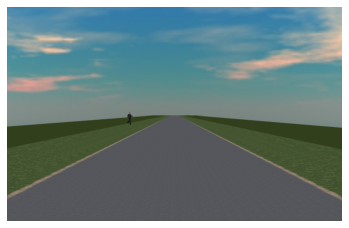

In [8]:
X = img_train[0].reshape(1, 480, 752, 3)
X_recon = od.vae(X)
plt.imshow(X.reshape(480, 752, 3))
plt.axis('off')
plt.show()

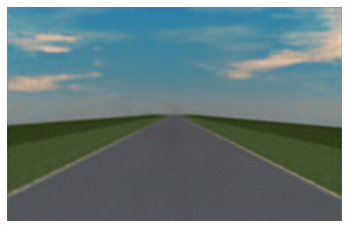

In [9]:
plt.imshow(X_recon.numpy().reshape(480, 752, 3))
plt.axis('off')
plt.show()

17300